[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/2_MDOFsimulator.ipynb)

# Simulation of multiple degrees-of-freedom (MDOF) systems

References:
- Khalid Jawed, "Notes on Discrete Simulation of Slender Structures", chapters 3 and 4.

Recall the equations of motion (with initial conditions) for a MDOF system subject to
conservative, non-conservative, and viscous forces, written as a system of first order ODEs:
$$ \begin{cases}
    \dot{v}_i = \frac{1}{m_i} \left(-\frac{\partial E_p}{\partial q_i} - c v_i
    + F_i\right) \\
    v_i = \dot{q}_i \\
    q_i(0) = q_{i0} \\
    v_i(0) = v_{i0}
\end{cases}
$$
where $q_i$ are the degrees of freedom ($i = 1,..,N$), $v_i$ are the associated
velocities, $m_i$ are the lumped masses, $c$ is the viscous dissipation coefficien,
$F_i$ are the non-conservative forces, and $E_p$ is the potential energy corresponding
to the conservative forces.

In [1]:
# Use JAX on CPU (needed on MacOS laptop because GPU is not supported)
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import jax.numpy as jnp
from jax import jacfwd, jit, grad, config, vmap
from functools import partial
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

# Set default data type to double precision: important for accurate ODE integration!
config.update("jax_enable_x64", True)

In [3]:
# Equations of motion (system of first order ODEs to integrate)
@partial(jit, static_argnames=("P",))
def equations_of_motion(t, z, P, m, c=0., F=0.):
    q, v = jnp.array_split(z, 2) # split state into positions and velocity
    dq_dt = v
    dv_dt = -grad(P)(q)/m-c*v/m+F/m
    return jnp.concatenate([dq_dt, dv_dt])

Let us define a function for the Jacobian of the system wrt to the state ($z$), which is
needed for implicit time integration schemes.

In [4]:
# Jacobian of the rhs of the system of equations of motion
@partial(jit, static_argnames=("P",))
def jacobian(t, z, P, m, c=0., F=0.):
    return jacfwd(equations_of_motion, argnums=1)(t, z, P, m, c, F)

### Example: 2 masses, 1 spring

In [8]:
# Initial conditions
q0 = jnp.array([0., 1.1])  # initial positions
v0 = jnp.array([0., 0.])  # initial velocities
z0 = jnp.concatenate([q0, v0])

# Masses and stiffnesses
m = jnp.ones(2)

# Potential energy
def S(q):
    return 0.5*(q[1]-q[0] - 1.)**2

# Kinetic energy
def K(v):
    return 0.5*jnp.sum(m * v**2)

# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = jnp.linspace(t_span[0], t_span[1], 1000)  # points at which to store the solution

# Solve the system using RK45 (explicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(S, m), t_eval=t_eval)
# Solve the system using BDF (implicit method)
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(S, m), method="BDF", t_eval=t_eval, jac=jacobian)

In [9]:
# Comparing the performance of explicit/implicit time integrators
print("Explicit time-stepping:")
%timeit sol = solve_ivp(equations_of_motion, t_span, z0, args=(S, m), t_eval=t_eval)
print("Implicit time-stepping:")
%timeit sol = solve_ivp(equations_of_motion, t_span, z0, args=(S, m), method="BDF", t_eval=t_eval, jac=jacobian)

Explicit time-stepping:
1.93 ms ± 37.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Implicit time-stepping:
5.63 ms ± 225 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


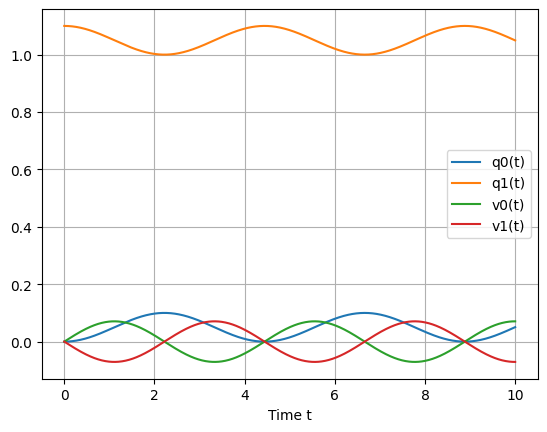

In [10]:
# Plot the results
plt.plot(sol.t, sol.y[0], label='q0(t)')
plt.plot(sol.t, sol.y[1], label='q1(t)')
plt.plot(sol.t, sol.y[2], label='v0(t)')
plt.plot(sol.t, sol.y[3], label='v1(t)')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

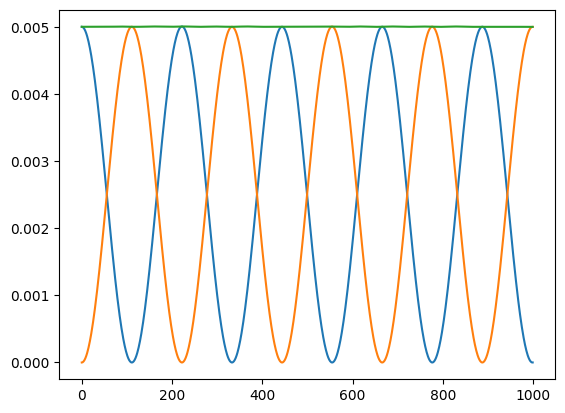

In [11]:
q, v = np.split(sol.y, 2)
potential_energy = vmap(S, in_axes=(1,))(q)
kinetic_energy = vmap(K, in_axes=(1,))(v)
plt.plot(potential_energy)
plt.plot(kinetic_energy)
plt.plot(potential_energy + kinetic_energy)
plt.show()

### Verlet time integration (optional)

In [ ]:
def velocity_verlet(t, dt, z, P, equations_of_motion, m, c=0., F=0.):
    q, v = jnp.split(z, 2) 
    a = equations_of_motion(t, z, P, m, c, F)[len(q):] 
    q = q + v*dt + 0.5*a*dt**2
    z = jnp.concatenate([q, v])
    new_a = equations_of_motion(t, z, P, m, c, F)[len(q):]
    v = v + 0.5*(new_a + a) * dt
    return jnp.concatenate([q, v])

In [ ]:
z = z0
dt = 0.001
times = np.arange(0., 10., dt)
zs = np.zeros((len(z0), len(times)))
for i,t in enumerate(times):
    z = velocity_verlet(t, dt, z, S, equations_of_motion, m) 
    zs[:,i] = z

In [ ]:
# Plot the results
plt.plot(times, zs[0], label='q0(t)')
plt.plot(times, zs[1], label='q1(t)')
plt.plot(times, zs[2], label='v0(t)')
plt.plot(times, zs[3], label='v1(t)')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

### Rigid spheres and elastic beam falling in a viscous fluid

In [12]:
N = 11 # number of spheres (must be odd)
l = 0.1 # total length of the rod
dl = l/(N-1)
xs = jnp.linspace(0., l, N).reshape(-1,1) # array of the x coords as a column
ys = jnp.zeros((N,1))
q0 = jnp.hstack([xs, ys]).ravel() # [x0, y0, x1, y1, ...]
v0 = jnp.zeros(2*N)
z0 = jnp.concatenate([q0, v0])

In [13]:
# Material parameters
E = 1e9 # Young's modulus
r0 = 1e-3 # beam radius
EA = E*np.pi*r0**2 # stretching stiffenss
EI = E*np.pi*r0**4/4 # bending stiffness
rho_m = 7000. # density of the metal (spheres)
rho_f = 1000. # density of the fluid
radii = 5e-3*np.ones(2*N) # radii of the spheres (2 per dof)
radii[N-1:N+1] = 25e-3
V = 4/3*np.pi*np.power(radii, 3) # volumes of the spheres
m = rho_m * V # masses of the spheres
mu = 1000. # fluid viscosity

# Viscous damping coefficients
c = 6*np.pi*mu*radii

In [14]:
# Buoyancy forces
y_components = np.ones(2*N)
y_components[::2] = 0.
F = -V*y_components*(rho_m-rho_f)*9.81

Define the functions needed to compute the curvatures and the stretching energy of the system.

In [15]:
# Geometry functions
def compute_edge_vectors(q):
    p_vec = q.reshape(-1,2)
    return p_vec[1:,:] - p_vec[:-1,:]

def compute_curvatures(edge_vectors_norm):
    cos_turning_angles = jnp.sum(edge_vectors_norm[1:] * edge_vectors_norm[:-1], axis=1)
    sin_turning_angles = jnp.cross(edge_vectors_norm[1:], edge_vectors_norm[:-1], axis=1)
    tan_theta_half = sin_turning_angles/(1+cos_turning_angles)
    return 2*tan_theta_half/dl

# Bending energy
def B(q):
    edge_vectors = compute_edge_vectors(q)
    edge_vectors_norm = edge_vectors / jnp.linalg.norm(edge_vectors, axis=1).reshape(-1,1)
    curvatures = compute_curvatures(edge_vectors_norm)
    return 0.5*EI*jnp.sum(curvatures**2*dl)

# Stretching energy
def S(q):
    edge_vectors = compute_edge_vectors(q)
    stretch = (1/dl)*jnp.linalg.norm(edge_vectors, axis=1)
    return 0.5*EA*jnp.sum((1.-stretch)**2*dl)

def P(q):
    return S(q) + B(q)

Then, we can integrate the equations of motion:

In [20]:
# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the solution

# Solve the system using RK45 (explicit method)
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), t_eval=t_eval)
# Solve the system using BDF (implicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), method="BDF", t_eval=t_eval, jac=jacobian)

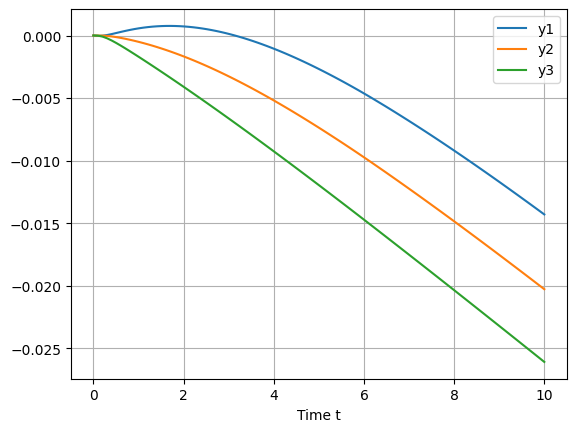

In [21]:
q, v = np.split(sol.y, 2)
plt.plot(sol.t, q[1], label='y1')
plt.plot(sol.t, q[3], label='y2')
plt.plot(sol.t, q[5], label='y3')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

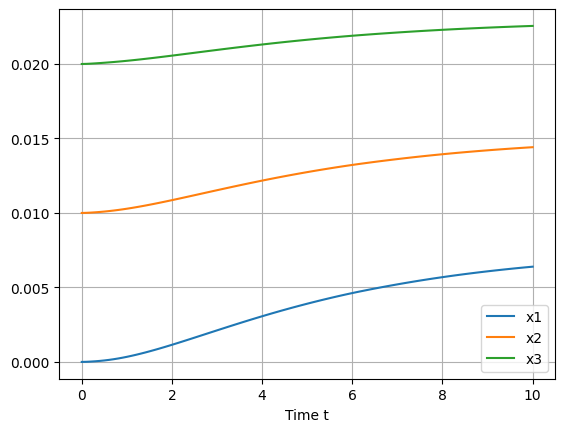

In [22]:
plt.plot(sol.t, q[0], label='x1')
plt.plot(sol.t, q[2], label='x2')
plt.plot(sol.t, q[4], label='x3')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

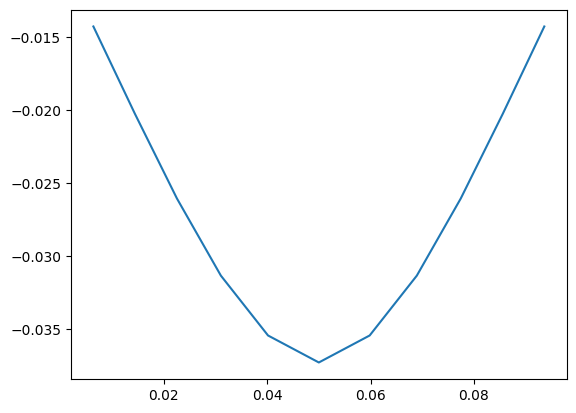

In [23]:
# Plot the final configuration of the beam
plt.plot(q[::2,-1],q[1::2,-1])
plt.show()

### Bending of a simply-supported rod under uniform load

In [24]:
N = 51 # number of nodes
l = 1. # total length of the rod
dl = l/(N-1)
xs = jnp.linspace(0., l, N).reshape(-1,1)
ys = jnp.zeros((N,1))
q0 = jnp.hstack([xs, ys]).ravel()
v0 = jnp.zeros(2*N)
z0 = jnp.concatenate([q0, v0])

In [25]:
E = 70e9 # Young's modulus
R = 0.013 # outer radius circular cross-section
r = 0.011 # inner radius circular cross-section
I = np.pi/4*(R**4 - r**4)
EA = E*np.pi*(R**2 - r**2) # stretching stiffness
EI = E*I # bending stiffness
rho = 2700 # material's density
m = np.pi*(R**2-r**2)*l*rho/(N-1) # array of nodal massess
c = 5. # damping, just to reach steady-state faster

Modify the equations of motion to enforce the boundary conditions (zero displacement and
velocity on the left end, zero vertical displacement and vertical velocity on the right end).

1. Compute the configuration of the rod in the time interval $[0,0.1]$ when a
   _distributed_ vertical load is applied to it (hint: distribute the load over the nodes). Perform the simulation for each value of the load in the
   interval $[1000,10000]$, with load increment $1000$. (Hint: use the `LSODA` solver in
   `solve_ivp`). 
2. For each load, plot the maximum vertical displacement of the rod as obtained from the
  simulation and from the linear beam theory.
2. Plot the final deformed configuration of the rod (load = 10000).

In [27]:
@partial(jit, static_argnames=("P",))
def equations_of_motion(t, z, P, m, c=0., F=0.):
    q, v = jnp.array_split(z, 2) # split state into positions and velocity
    q = q.at[0:2].set(0)
    q = q.at[-1].set(0)
    v = v.at[0:2].set(0)
    v = v.at[-1].set(0)
    dq_dt = v
    dv_dt = -grad(P)(q)/m-c*v/m+F/m
    return jnp.concatenate([dq_dt, dv_dt])

In [28]:
@partial(jit, static_argnames=("P",))
def jacobian(t, z, P, m, c=0., F=0.):
    return jacfwd(equations_of_motion, argnums=1)(t, z, P, m, c, F)

In [29]:
t_span = (0, 0.1)
t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the solution

y_components = np.ones(2*N)
y_components[::2] = 0. # select the dofs corresponding to y components

y_theory = []
y_num = []

loads = np.linspace(1000, 10000, 10)

for load in loads:
    print(load)
    P0 = load/N # distribute load over nodes
    F = -P0*y_components
    # vertical displacement according to linear beam theory
    w = -load/l
    y_theory.append(5*w*l**4/(384*EI))

    sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), method="LSODA", t_eval=t_eval, jac=jacobian)

    q, v = np.split(sol.y, 2)
    y_num.append(q[N][-1]) # record y-displacement of the midpoint at final time

1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0


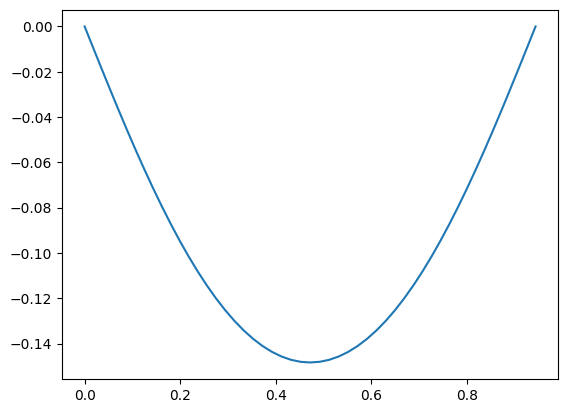

In [30]:
# Final configuration (maximum load)
plt.plot(q[::2,-1],q[1::2,-1])
plt.show()

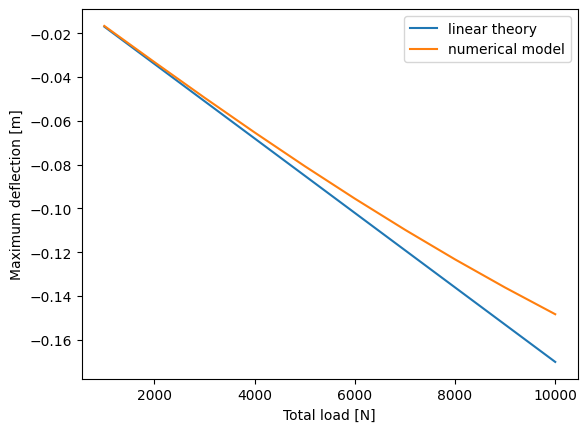

In [31]:
plt.plot(loads, y_theory, label="linear theory")
plt.plot(loads, y_num, label="numerical model")
plt.xlabel("Total load [N]")
plt.ylabel("Maximum deflection [m]")
plt.legend()
plt.show()

#### Example using Diffrax (optional)

`Diffrax` ([docs](https://docs.kidger.site/diffrax/)) is a JAX-based library providing numerical solvers for differential equations.

In [32]:
# Needed on Colab (also restart)
!pip install diffrax

/Users/au731137/mambaforge/envs/datasim/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [diffrax]m5/6 [diffrax]ix]


In [33]:
from diffrax import diffeqsolve, ODETerm, ImplicitEuler, PIDController, Heun, Midpoint

def equations_of_motion(t, z, args):
    P, m, c, F = args
    q, v = jnp.array_split(z, 2) # split state into positions and velocity
    q = q.at[0:2].set(0)
    q = q.at[-1].set(0)
    v = v.at[0:2].set(0)
    v = v.at[-1].set(0)
    dq_dt = v
    dv_dt = -grad(P)(q)/m-c*v/m+F/m
    return jnp.concatenate([dq_dt, dv_dt])

term = ODETerm(equations_of_motion)
solver = Heun() # ImplicitEuler()
stepsize_controller = PIDController(rtol=1e-4, atol=1e-4)
P0 = 10000./N # distribute load over nodes
y_components = np.ones(2*N)
y_components[::2] = 0. # select the dofs corresponding to y components
F = -P0*y_components
solution = diffeqsolve(term, solver, t0=0, t1=0.1, dt0=1e-4, y0=z0, args=(P, m, c, F), stepsize_controller=stepsize_controller, max_steps=1000000)

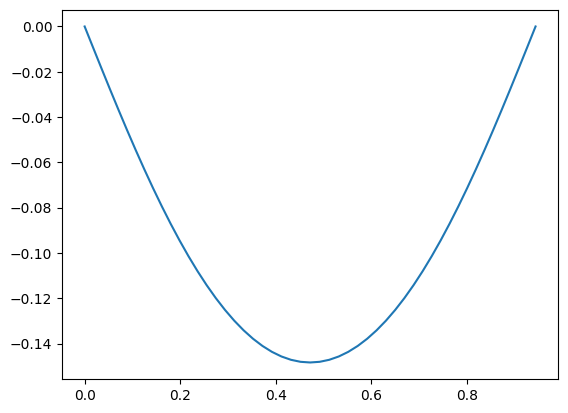

In [34]:
q, v = np.split(solution.ys[0], 2)
plt.plot(q[::2],q[1::2])
plt.show()